In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install opencv-python

In [ ]:
import cv2
import os.path
path = '/content/drive/MyDrive/videodataset/frames/'
vidcap = cv2.VideoCapture('/content/drive/MyDrive/videodataset/mallvideofinal.avi')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(path +'image'+str(count)+'.jpg' , image)     
    return hasFrames
sec = 0
frameRate = 0.2 
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.1.5

In [ ]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from numpy.random import seed
seed(1)

import scipy
from scipy import spatial
from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose,  Activation, BatchNormalization,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.applications import vgg16
import tensorflow.keras.backend as K

In [ ]:
images=np.load('/content/drive/MyDrive/videodataset/images.npy')
images_density=np.load('/content/drive/MyDrive/videodataset/images_density.npy')
images_gt = np.load('/content/drive/MyDrive/videodataset/images_gt.npy', allow_pickle=True)

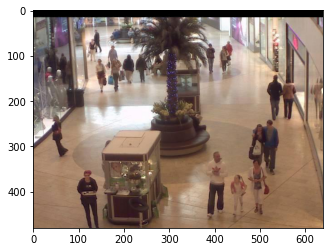

In [ ]:
img=plt.imshow(images[200])

number of people: 26.00


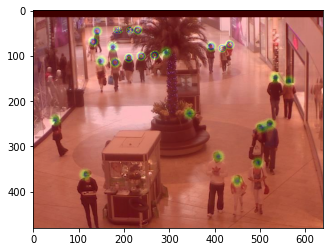

In [ ]:
plt.imshow(images[200])
plt.imshow(images_density[200],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[200]/1000))

In [ ]:
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model
    
    
    
    
    
    
    


In [ ]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)

In [ ]:
lr=1e-5
model=Crowd_CNN()
model.load_weights('/content/Crowd-CNN.h5')
Optimizer=Nadam(lr)
# model.summary()

In [ ]:
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
X_train, X_val, Y_train, Y_val=train_test_split(images,images_density,test_size=0.15,random_state=70)

In [ ]:
Y_train=np.expand_dims(Y_train, -1)
Y_val=np.expand_dims(Y_val,-1)

In [ ]:
def get_patch(X,Y):
  x_patch=np.zeros([3*X.shape[0],size[0],size[0],size[1],3])
  y_patch=np.zeros([3*y.shape[0],size[0],size[0],size[1],1])

  for i in range(X.shape[0]):
    for j in range(3):

      x1=np.random.randint(0,X.shape[1]-size[0]-1)
      y1=np.random.randint(0,X.shape[2]-size[1]-1)
      x2=size[0]+x1
      y2=size[1]+y1

      x_patch[3*i+j]=X[i,x1:x2,y1:y2,:]
      y_patch[3*i+j]=Y[i,x1:x2,y1:y2,:]

  return x_patch,y_patch

In [ ]:
for i in model.layers[:5]:
     i.trainable=False
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
for i in range(1):
     x_patch,y_patch=get_patch(X_train, Y_train)
     x_patch_val,y_patch_val=get_patch(X_val, Y_val)
     model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))


In [ ]:
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(images,images_density,test_size=0.15,random_state=7)
model = Crowd_CNN()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Accuracy: %.3f%%" % (result*100.0))


Accuracy: 87.64%


In [ ]:
test_size = 2


In [ ]:
idx_test = np.random.randint(images.shape[0], size=test_size)
idx_test

array([907, 252])

In [ ]:
X = images[idx_test]/255
y = images_density[idx_test]

number of people: 42.99


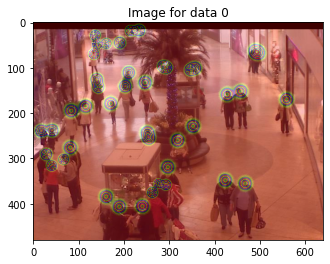

In [ ]:
plt.title("Image for data 0")
plt.imshow(X[0])
plt.imshow(y[0],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[0]/1000))

number of people: 18.98


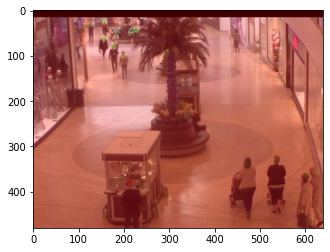

In [ ]:
plt.imshow(X[1])
plt.imshow(y[1],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[1]/1000))

In [ ]:
y = np.expand_dims(y,-1)
y.shape

(2, 480, 640, 1)

In [ ]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

In [ ]:
for i in range(0, test_size):

  y_predict = full_eval(X[i:i+1],smooth=True)

  print("Prediction for data {}".format(i))
  print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
  print('Exact Number of people: %4.2f' %(np.sum(y[i])/1000))
  print()


Predicted Number of people: 44.65
Exact Number of people: 42.99


<Figure size 432x288 with 0 Axes>

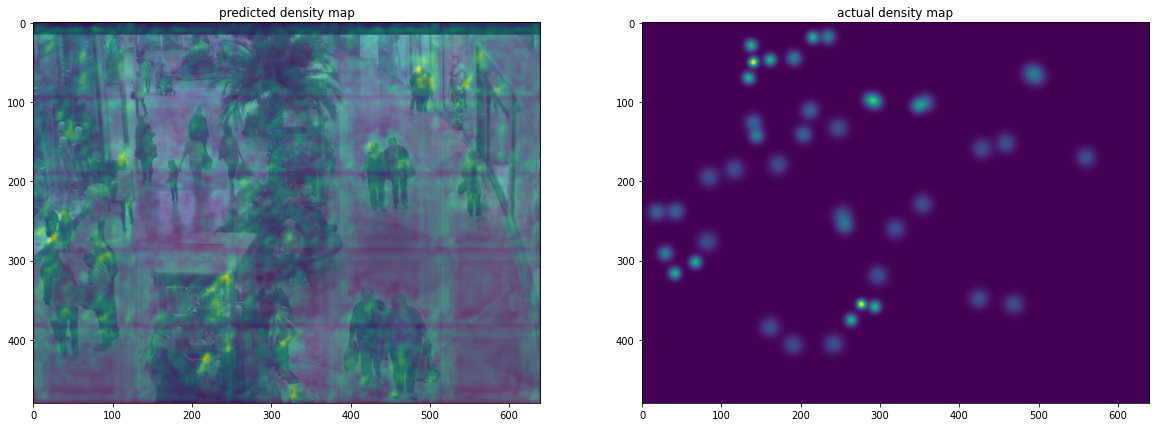

In [ ]:
e=0
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

axarr[0].title.set_text('predicted density map')
axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict, alpha=0.7)


axarr[1].title.set_text('actual density map')
axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))

In [ ]:
e=1
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 


axarr[0].title.set_text('predicted density map')
# axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict)

axarr[1].title.set_text('actual density map')
# axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = image.load_img(path, target_size=(480, 640))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images[0] = images[0] / 255

  y_predict = full_eval(images,smooth=True)

  print("\nPrediction for data {}".format(fn))
  print('Predicted Number of people: %4.2f\n' %(np.sum(y_predict)/1000))